In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.DataFrame(columns=['type', 'fold', 'img_path', 'mask_path'])
# for i in [1, 2, 3, 4, 5]:
for i in [1]:
    for d in ['train', 'val', 'test']:
        imgs  = []
        masks = []
        for f in os.listdir(f'data/Fold{i}/{d}'):
            imgs.append(f'data/Fold{i}/{d}/{f}')

        for f in os.listdir(f'data/Fold{i}/{d}annot'):
            masks.append(f'data/Fold{i}/{d}annot/{f}')
            
        l = len(os.listdir(f'data/Fold{i}/{d}'))
        for j in range(l):
            img_path  = imgs[j]
            mask_path = masks[j]
            df = pd.concat([df, pd.DataFrame([[d, f'Fold{i}', img_path, mask_path]], columns=['type', 'fold', 'img_path', 'mask_path'])], axis=0)
df = df.reset_index(drop=True)
df

type   fold                      img_path  \
0    train  Fold1   data/Fold1/train/A00010.jpg   
1    train  Fold1  data/Fold1/train/A000100.jpg   
2    train  Fold1  data/Fold1/train/A000110.jpg   
3    train  Fold1  data/Fold1/train/A000120.jpg   
4    train  Fold1  data/Fold1/train/A000130.jpg   
..     ...    ...                           ...   
376   test  Fold1     data/Fold1/test/A_0_4.jpg   
377   test  Fold1     data/Fold1/test/A_0_5.jpg   
378   test  Fold1     data/Fold1/test/A_0_6.jpg   
379   test  Fold1     data/Fold1/test/A_0_8.jpg   
380   test  Fold1     data/Fold1/test/A_0_9.jpg   

                             mask_path  
0     data/Fold1/trainannot/A00010.png  
1    data/Fold1/trainannot/A000100.png  
2    data/Fold1/trainannot/A000110.png  
3    data/Fold1/trainannot/A000120.png  
4    data/Fold1/trainannot/A000130.png  
..                                 ...  
376     data/Fold1/testannot/A_0_4.png  
377     data/Fold1/testannot/A_0_5.png  
378     data/Fold1/testannot/A_0_6.png  
379     data/Fold1/testannot/A_0_8.png  
380     data/Fold1/testannot/A_0_9.png  

[381 rows x 4 columns]

In [3]:
import tensorflow.keras as keras
class Dataset(keras.utils.Sequence):
    def __init__(
            self, 
            dataframe,
            batch_size=32, 
            shuffle=True,
            img_size=(256,256)
    ):
        self.df = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.img_size = img_size
        self.on_epoch_end()    

    def __getitem__(self, ids):
        #print(self.indexes)
        indexes = self.indexes[ids*self.batch_size:(ids+1)*self.batch_size]
        b = len(indexes)
        #indexes = self.indexes[0:8]
        b_img  = np.empty((b, 256, 256, 3))
        b_mask = np.empty((b, 256, 256, 1))
        i = 0


        for j in indexes:
            img, mask  = self.read_img(j)
            b_img[i, :, :, :]  = img
            b_mask[i, ...] = mask
            i = i + 1


        return b_img/255, b_mask 
        
    def __len__(self):
        return round(len(self.df) / self.batch_size)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))

        if self.shuffle == True:
            np.random.shuffle(self.indexes)      


    def read_img(self, i):
        # read data
        image1 = cv2.imread(self.df['img_path'][i])
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image1, self.img_size)

        mask  = cv2.imread(self.df['mask_path'][i], 0)
        mask  = cv2.resize(mask, self.img_size)
        mask  = np.where(mask>112, 1, 0) 
        mask  = np.expand_dims(mask, axis=2)

        return image, mask 


In [4]:
train_df = df[df['type']=='train'].reset_index(drop=True)
val_df   = df[df['type']=='val'].reset_index(drop=True)
test_df  = df[df['type']=='test'].reset_index(drop=True)

train_dataset = Dataset(dataframe=train_df, batch_size=2, shuffle=True)
vala_dataset  = Dataset(dataframe=val_df,batch_size=1,shuffle=True)
test_dataset  = Dataset(dataframe=test_df,batch_size=1,shuffle=True)

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

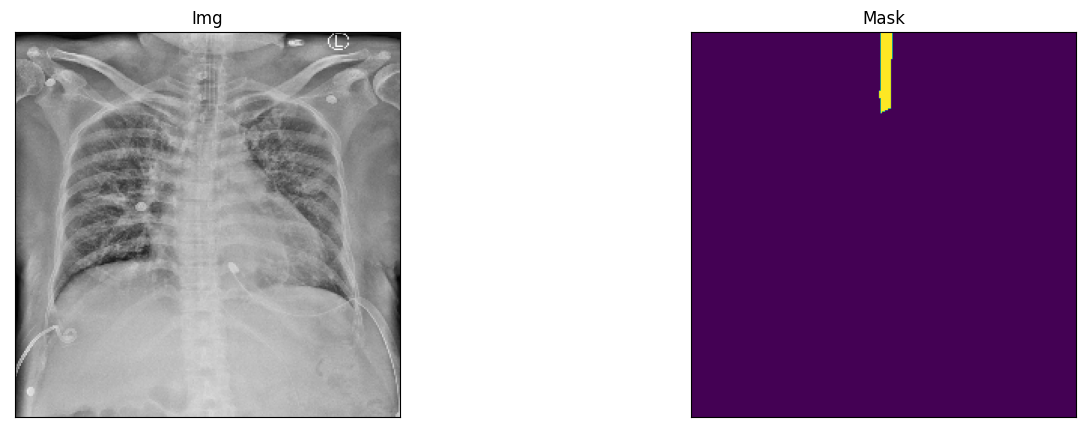

In [6]:
visualize(img=(train_dataset[0][0][0]*255).astype('int'), mask=train_dataset[0][1][0])

In [7]:
from keras_unet_collection import models, utils

* input_size：一个元组或列表，定义了输入张量的形状。
    * models.resunet_a_2d, models.transunet_2d, and models.swin_unet_2d只支持int，其他也支持input_size=(None, None, 3)。
    * activation='PReLU'与 input_size=(None, None, 3) 不兼容。
* filter_num：一个列表，定义了每个下采样和上采样块的卷积滤波器的数量。
    * 对于unet_2d, att_unet_2d, unet_plus_2d, r2_unet_2d，深度2是预期的。
    * 对于resunet_a_2d和u2net_2d，深度为3是预期的。
* n_labels：输出目标的数量，例如，对于二进制分类，n_labels=2。
* activation：隐藏层的激活函数。可用的选择有 "ReLU"、"LeakyReLU"、"PReLU"、"ELU"、"GELU"、"Snake"。
* output_activation：输出层的激活函数。建议选择 "Sigmoid"、"Softmax"、None（线性）、"Snake"。
* batch_norm：如果指定为True，所有卷积层将被配置为 "Conv2D-BN-激活 "的堆栈。
* stack_num_down：每个下采样层的卷积层数量。
* stack_num_up：每个上采样级别的卷积层（连接后）的数量。
* pool：下采样（编码）块的配置。
    * pool=False：用一个卷积层进行下采样（2×2的卷积核，2个步长；可选择批量归一化和激活）。
    * pool=True或pool='max'用最大池子层进行下采样。
    * pool='ave'下采样，带有平均池层。
* unpool：上采样（解码）块的配置。
    * unpool=False：用转置卷积层进行上采样（2-by-2卷积核，2个步长；可选择批量归一化和激活）。
    * unpool=True或unpool='bilinear' 用双线性插值进行上升采样。
    * unpool='nearest' 带反射填充的上采样。
* name：用户指定的配置的层和模型的前缀。使用keras.models.Model.summary来确定每个层的确切名称。

In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size = (256,256), num_classes=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
# from keras_unet_collection import losses

# def hybrid_loss(y_true, y_pred):

#     loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
#     loss_iou = losses.iou_seg(y_true, y_pred)
    
#     # (x) 
#     #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)
    
#     return loss_focal+loss_iou #+loss_ssim


# model.compile(loss=[hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss, hybrid_loss],
#                   loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
#                   optimizer=keras.optimizers.Adam(learning_rate=1e-4))

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K
def DICE(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def BCE(y_true, y_pred):
    return 0.01 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

def BCE_DICE_loss(y_true, y_pred):
    return BCE(y_true, y_pred) + DICE(y_true, y_pred)

def IoU(y_true,y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)    
    intersection = K.sum(y_true * y_pred)
    union = (K.sum(y_true) + K.sum(y_pred) + 1)  
    return intersection/union

In [11]:
# from tensorflow.keras.metrics import IoU
from tensorflow.keras.optimizers import Adam
from accum_optimizer import AccumOptimizer  # 梯度累加
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

model.compile(optimizer = Adam(learning_rate=1e-3), loss = DICE, metrics=[DICE, IoU])
#model.compile(optimizer = Adam(learning_rate=1e-5), loss = DICE)
# 設置 EarlyStopping 回調函數
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# 設置 ModelCheckpoint 紀錄最佳權重
model_checkpoint = ModelCheckpoint('best_weights_fold5.h5', save_best_only=True, save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.003,patience=3, min_lr=0.00005)
# 訓練模型
# history = model.fit(X_train_augmented, epochs=10000, validation_data=X_val_augmented, callbacks=[early_stopping, model_checkpoint])
#history = model.fit(train_generator, epochs=10000, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint])
history = model.fit(train_dataset, epochs=100, validation_data=vala_dataset, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/100
144/144 [==============================] - 57s 340ms/step - loss: 0.6959 - DICE: 0.6957 - IoU: 0.1520 - val_loss: 0.9982 - val_DICE: 0.9982 - val_IoU: 3.5523e-10
Epoch 2/100
144/144 [==============================] - 47s 324ms/step - loss: 0.4641 - DICE: 0.4633 - IoU: 0.2682 - val_loss: 0.9980 - val_DICE: 0.9980 - val_IoU: 1.8139e-12
Epoch 3/100
144/144 [==============================] - 47s 326ms/step - loss: 0.4359 - DICE: 0.4353 - IoU: 0.2822 - val_loss: 0.9247 - val_DICE: 0.9247 - val_IoU: 0.0367
Epoch 4/100
144/144 [==============================] - 46s 318ms/step - loss: 0.3855 - DICE: 0.3850 - IoU: 0.3073 - val_loss: 0.4945 - val_DICE: 0.4945 - val_IoU: 0.2522
Epoch 5/100
144/144 [==============================] - 46s 314ms/step - loss: 0.3371 - DICE: 0.3368 - IoU: 0.3314 - val_loss: 0.6290 - val_DICE: 0.6290 - val_IoU: 0.1848
Epoch 6/100
144/144 [==============================] - 47s 326ms/step - loss: 0.3051 - DICE: 0.3048 - IoU: 0.3474 - val_loss: 0.4303 - val_DIC

In [12]:
# model.compile(optimizer = Adam(learning_rate=1e-3), loss = DICE, metrics=[DICE, IoU])
# history2 = model.fit(train_dataset, initial_epoch=40, epochs=100, validation_data=vala_dataset, callbacks=[early_stopping, model_checkpoint, reduce_lr])

# import tensorflow as tf
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.losses import categorical_crossentropy
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

# #model.compile(optimizer = Adam(learning_rate=1e-5), loss = BCE_DICE_loss, metrics=[BCE, DICE, IoU])
# model.compile(optimizer = Adam(learning_rate=1e-3), loss = DICE)

In [13]:
# N_epoch = 200 # number of epoches
# N_batch = 100 # number of batches per epoch
# N_sample = 32 # number of samples per batch

# tol = 0 # current early stopping patience
# max_tol = 2 # the max-allowed early stopping patience
# min_del = 0 # the lowest acceptable loss value reduction 

# # loop over epoches
# for epoch in range(40):    
#     if epoch == 25:
#         model.compile(optimizer = Adam(learning_rate=1e-4), loss = DICE)
#         print('將lr改為1e-4')
#     print(f'epoch {epoch}:')
#     # loop over batches
#     step = 1
#     total_loss = 0
#     for img, mask in train_dataset:
#         # train on batch
#         loss_ = model.train_on_batch(img, mask)
#         total_loss = total_loss + loss_
#         print(f'({step}/{len(train_dataset)}): {total_loss / step}', end='\r')
#         step = step + 1 
#     print()
    

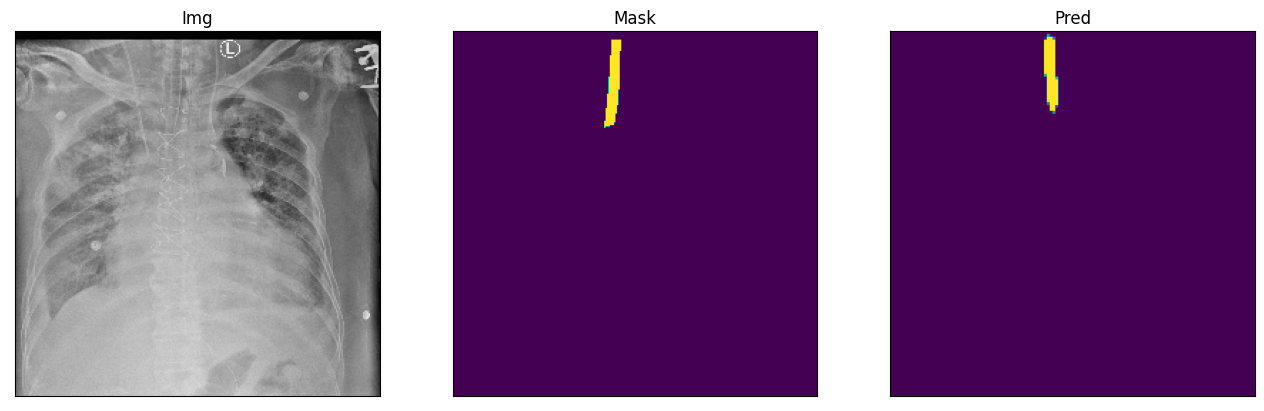

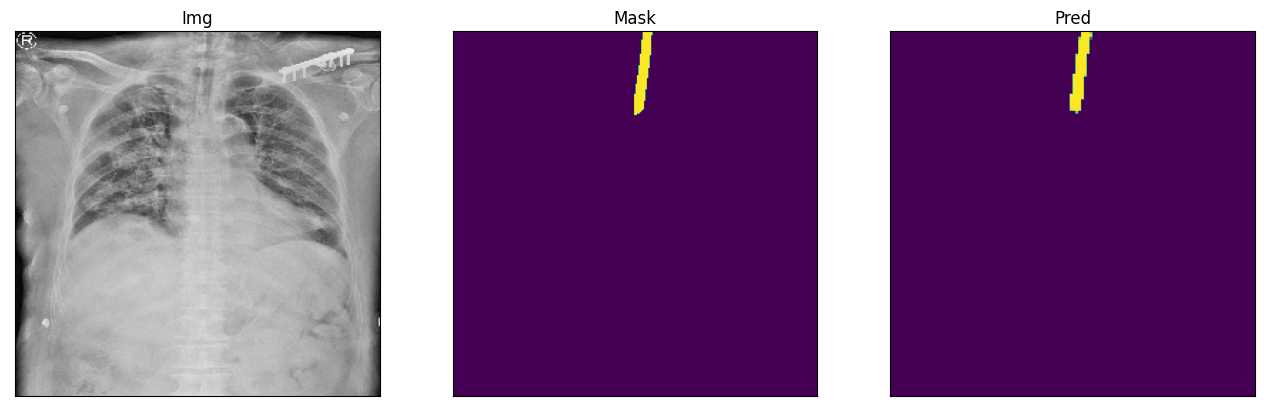

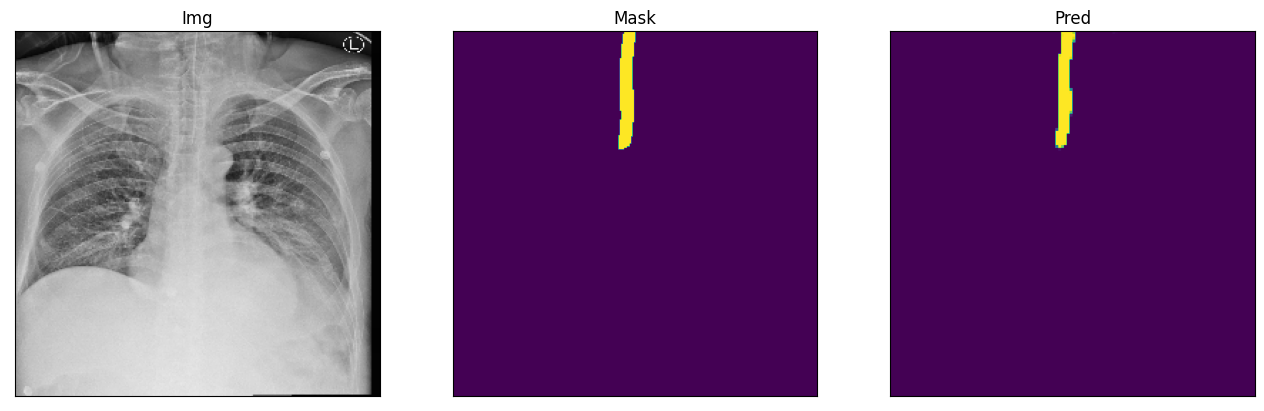

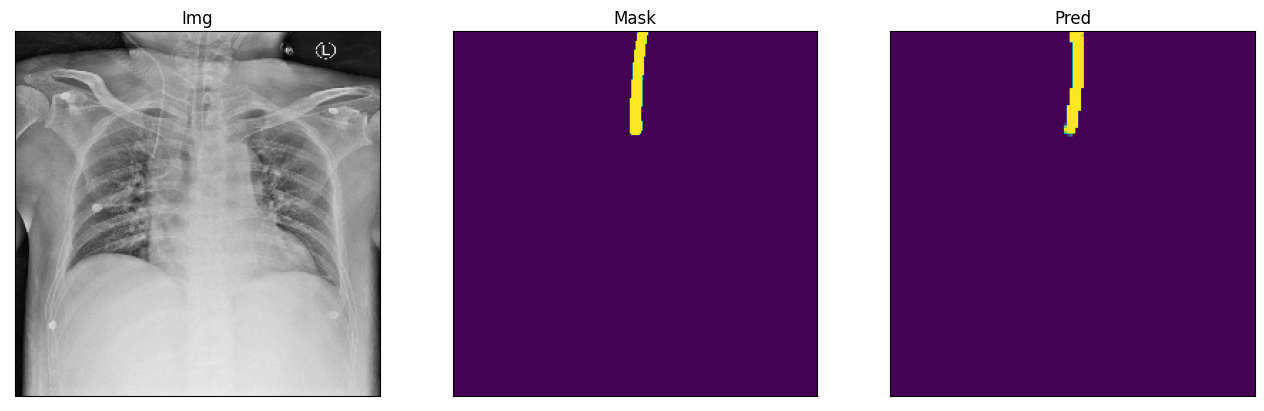

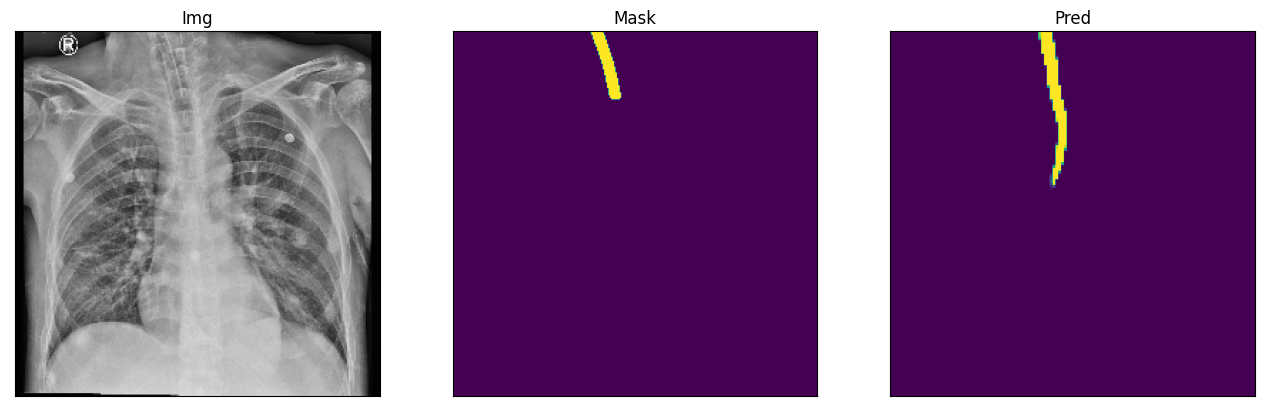

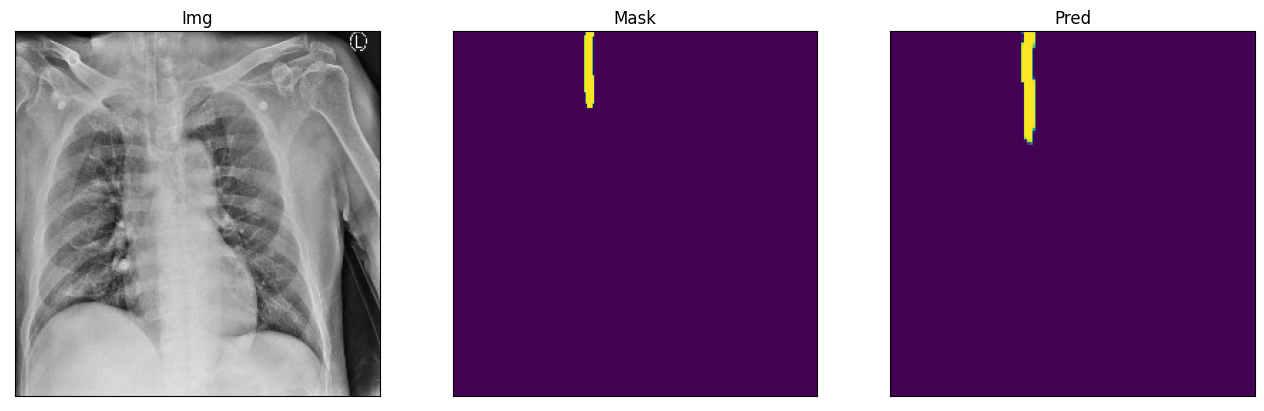

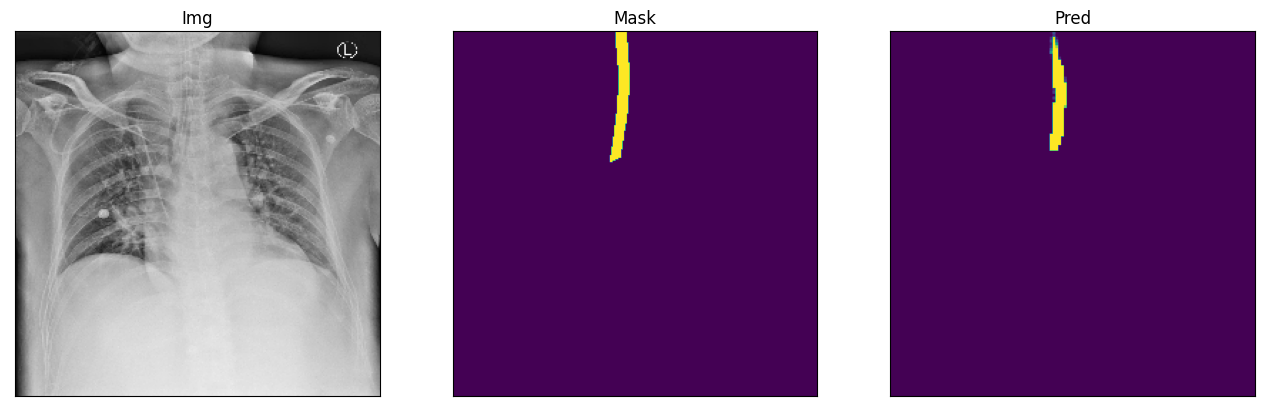

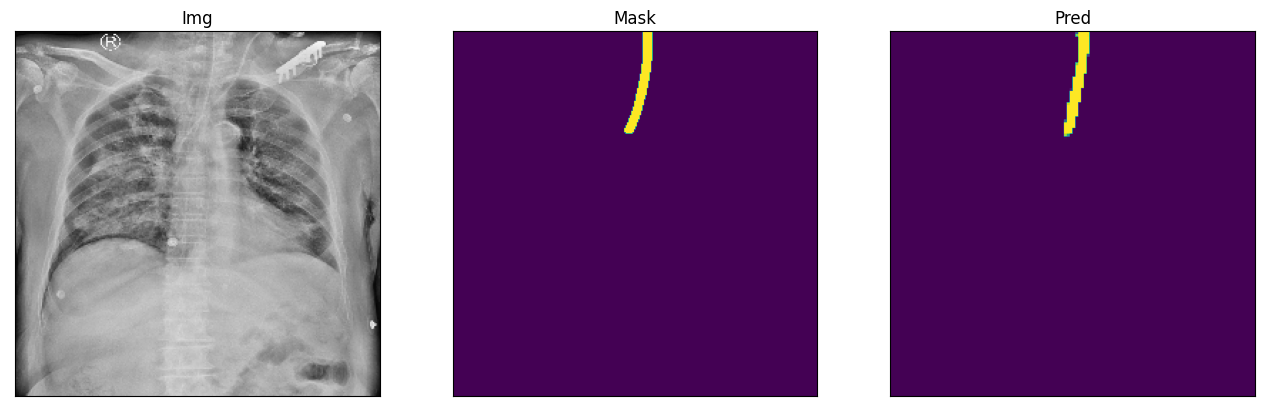

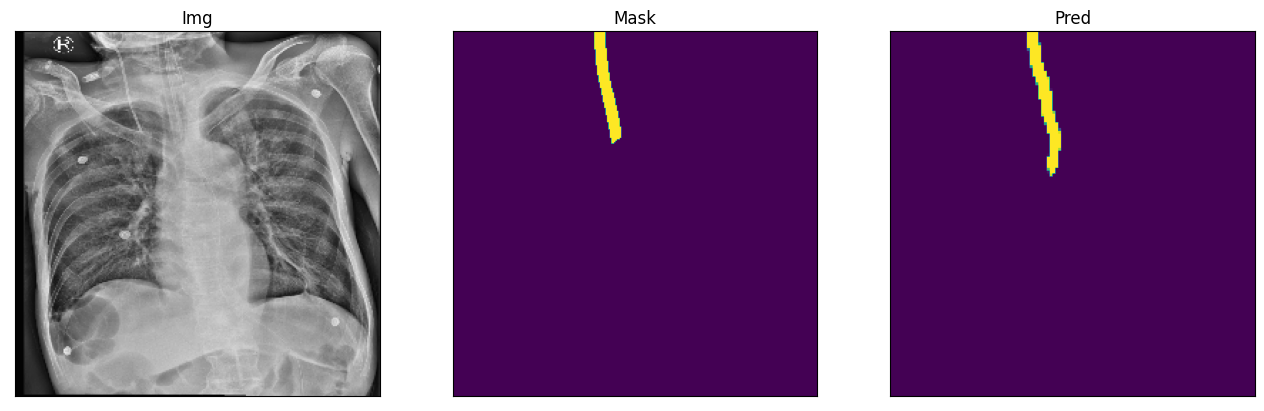

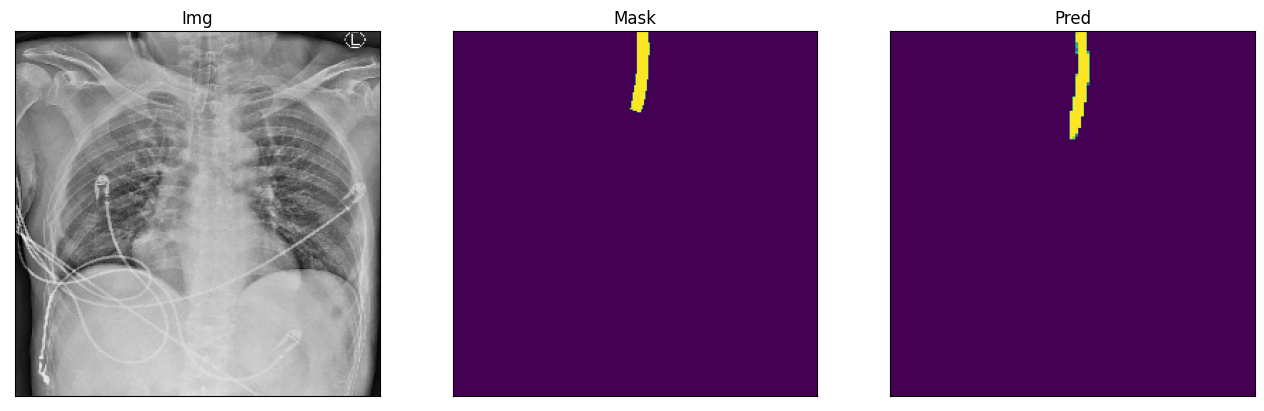

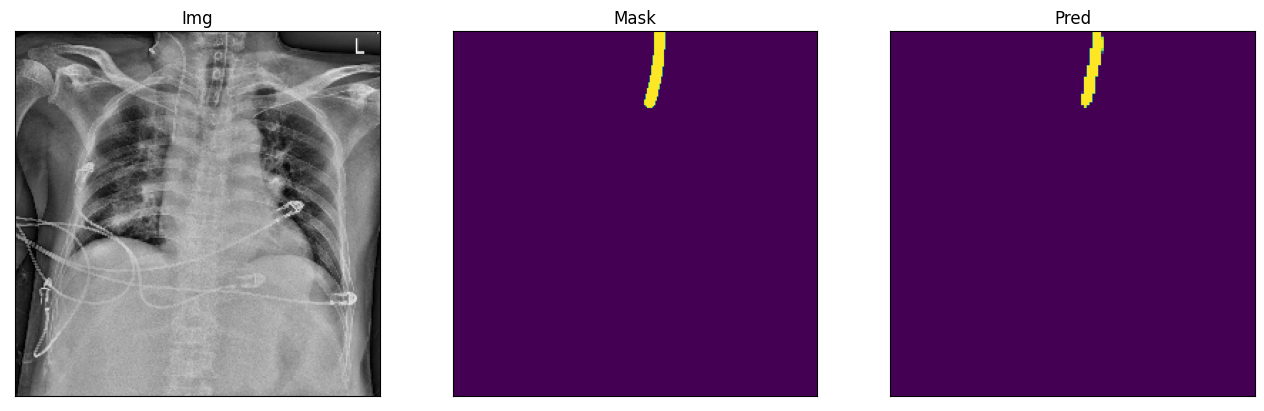

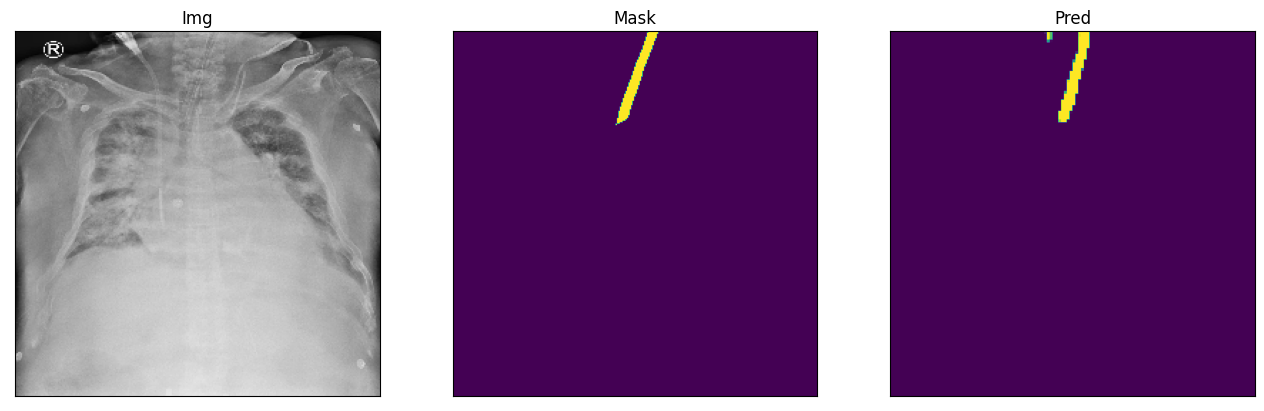

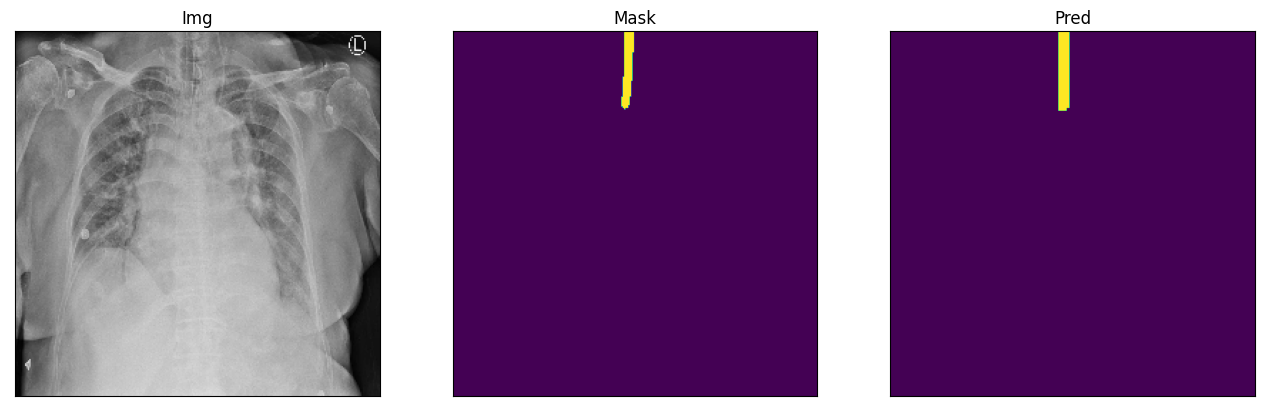

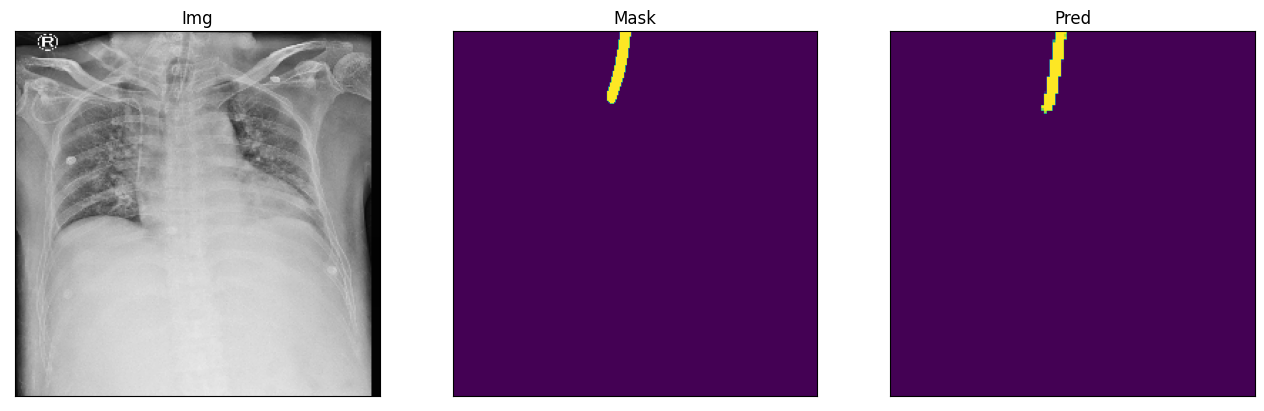

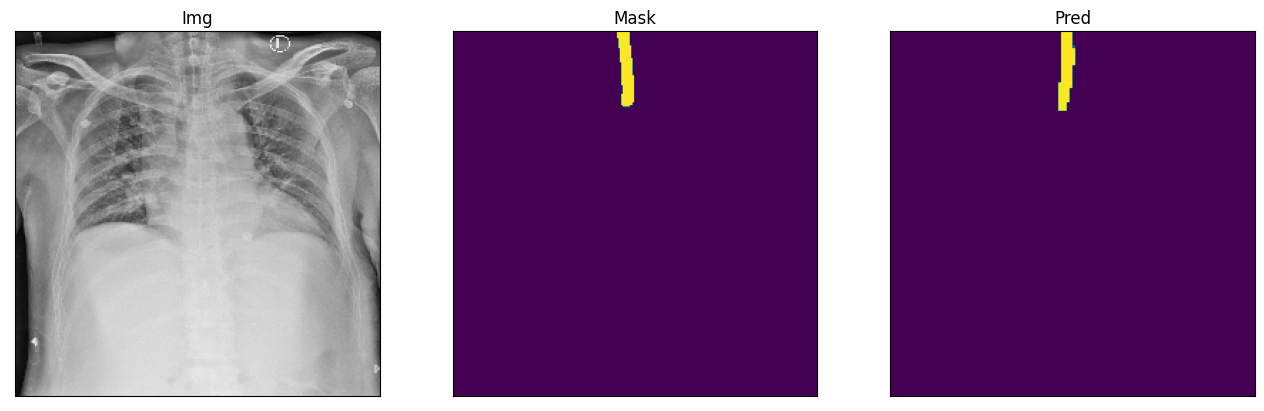

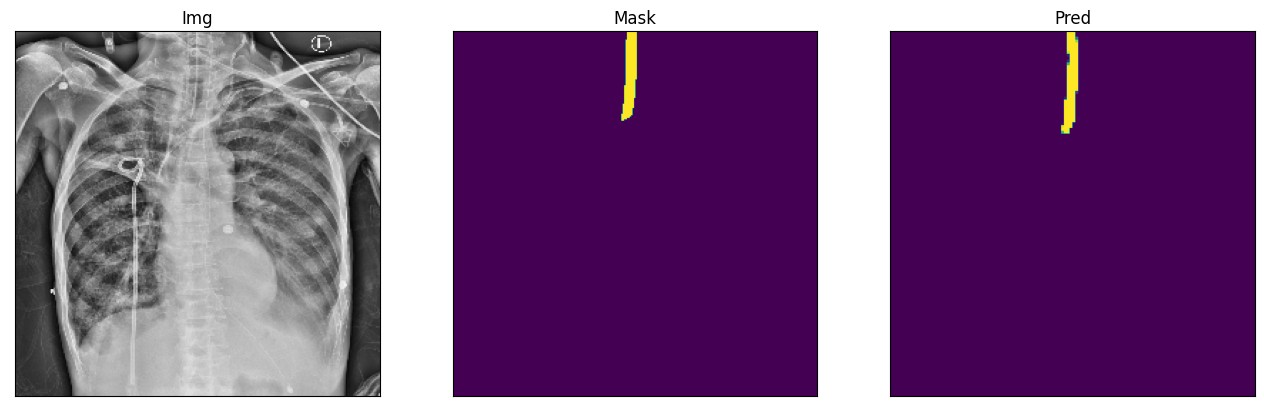

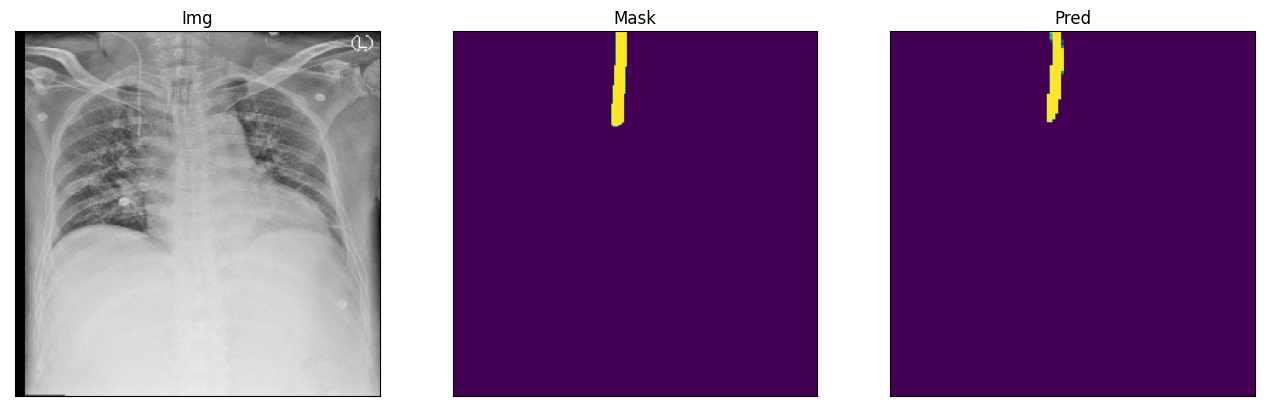

In [14]:
a = 0
for img, mask in test_dataset:
    mask_pred =model.predict(img)
    img = img * 255
    for i in range(mask_pred.shape[0]):
        visualize(img=img[i].astype('int'), mask=mask[i], pred=mask_pred[i])
    if a>15:
        break
    a =a +1

In [15]:
a= mask[0].astype('float32')
b=mask_pred[0].astype('float32')
iou_loss = IoU(a,b)
iou_loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.42520007>

In [16]:
def read_img_size(imgpath):
    # os.mkdir('%s_New'%(imgpath))
    image_folder = imgpath
    images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    image_cropSize_list = []
    image_orlSize_list = []
    for img in images:
        orl_img = cv2.imread(img)
        image = cv2.cvtColor(orl_img, cv2.COLOR_BGR2GRAY)
        orl_img_shape = np.array(image).shape
        image_orlSize_list.append(np.array(orl_img_shape))

    return np.array(image_orlSize_list)

In [17]:
test_img_size = read_img_size('data/Fold1/test')
testannot_img_size = read_img_size('data/Fold1/testannot')

In [18]:
testannot_img_size[1]

array([3028, 2517])

In [19]:
pixel = 72
mean_errorYG = 0
mean_errorYGforP05 = 0
mean_errorYGforP10 = 0
total = 0
totalforP05 = 0
totalforP10 = 0
for img, mask in test_dataset:
    mask_pred =model.predict(img)
    # img = img * 255
    # print(mask_pred.shape[0])
    for i in range(mask_pred.shape[0]):
        # visualize(img=img[i].astype('int'), mask=mask[i], pred=mask_pred[i])
        #取得testannot crop之後的大小，並對256*256的圖進行resize，還原至crop後的大小
        a,b             = testannot_img_size[i]
        mask_reSize     = cv2.resize(mask[i],(b,a))
        predmask_resize = cv2.resize(mask_pred[i],(b,a))

        _,mr                = cv2.threshold(mask_reSize, 0.5, 255, cv2.THRESH_BINARY)
        _,mpr               = cv2.threshold(predmask_resize, 0.5, 255, cv2.THRESH_BINARY)


    #邊緣檢測
        #將mask_reorlSize轉換成unit8的形式
        x=cv2.convertScaleAbs(mr)
        y=cv2.convertScaleAbs(mpr)

        _,aa = cv2.threshold(x, 0.5, 255, cv2.THRESH_BINARY)
        _,bb = cv2.threshold(y, 0.5, 255, cv2.THRESH_BINARY)

        # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
        contours,  hierarchy    = cv2.findContours(image=aa, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        contours2, hierarchy2   = cv2.findContours(image=bb, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

        #尋找最長的邊緣檢測並保留，以去除其餘的雜訊
        array = []
        for i in range(len(contours2)):
            array.append(len(contours2[i]))
        maxlen = np.argmax(array)  
        Newcontours2 = contours2[maxlen]

        # # draw contours on the original image
        image_copy  = mr.copy()
        image_copy2 = mpr.copy()
        # # print(contours)
        cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255))
        cv2.drawContours(image=image_copy2, contours=Newcontours2, contourIdx=-1, color=(255))


    #誤差評估
        #取得mask端點的y座標
        mask_has_ones = np.any(image_copy == 255, axis=1)
        #取得pre_mask端點的y座標
        pre_has_ones = np.any(image_copy2 == 255, axis=1)
        
        mask_ylen = np.max(np.where(mask_has_ones)[0])
        pred_ylen = np.max(np.where(pre_has_ones)[0])
        loss_ylen = (np.absolute(int(pred_ylen)-int(mask_ylen)))


        #平均誤差公分
        mean_errorYG += loss_ylen
        total += 1

        #誤差在0.5cm內準確率
        if(loss_ylen<=(pixel/2)):
            # mean_errorYGforP05 += loss_ylen
            totalforP05 += 1
        if(loss_ylen<=(pixel)):
            # mean_errorYGforP05 += loss_ylen
            totalforP10 += 1

mean_error = (mean_errorYG/total)/pixel
print("平均誤差公分",mean_error)
print(total)
mean_errorForP05 = (totalforP05/total)*1
print("誤差在0.5cm內準確率",mean_errorForP05)
print(totalforP05)
mean_errorForP10 = (totalforP10/total)*1
print("誤差在1.0cm內準確率",mean_errorForP10)
print(totalforP10)

平均誤差公分 2.3933215130023644
47
誤差在0.5cm內準確率 0.425531914893617
20
誤差在1.0cm內準確率 0.5319148936170213
25
